<a href="https://colab.research.google.com/github/tarunchand/Big-Data/blob/main/Big_Data_Week8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 41 kB/s 
     |████████████████████████████████| 199 kB 49.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845514 sha256=3b6f139bedccdef0456e78885a3fb61a4781a8ad98d0c3f48d100cf7d87c01af
  Stored in directory: /root/.cache/pip/wheels/42/59/f5/79a5bf931714dcd201b26025347785f087370a10a3329a899c
Successfully built pyspark


In [ ]:
from pyspark import SparkContext, SparkConf

# Initializing Spark
conf=SparkConf().setAppName("KDDCup_Analytics").setMaster("local[*]")
sc=SparkContext(conf=conf)

In [ ]:
sc.defaultParallelism


2

In [ ]:
KDDcup_rdd = sc.textFile("./kddcup.data.gz", 8)

In [ ]:
KDDcup_rdd.take(5)

['0,tcp,http,SF,215,45076,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,162,4528,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1,1,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,236,1228,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.00,0.00,0.00,0.00,1.00,0.00,0.00,2,2,1.00,0.00,0.50,0.00,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,233,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.00,0.00,0.00,0.00,1.00,0.00,0.00,3,3,1.00,0.00,0.33,0.00,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,3,0.00,0.00,0.00,0.00,1.00,0.00,0.00,4,4,1.00,0.00,0.25,0.00,0.00,0.00,0.00,0.00,normal.']

In [ ]:
KDDcup_rdd.count()

3409269

In [ ]:
Normal_rdd = KDDcup_rdd.filter(lambda line: 'normal.' in line)
Normal_rdd.count()

725530

In [ ]:
Split_rdd = KDDcup_rdd.map(lambda line: line.split(","))
Label_rdd = Split_rdd.map(lambda item: item[-2]).distinct() # Get last index for "labels"
Label_rdd.collect()

['normal.',
 'buffer_overflow.',
 'loadmodule.',
 'perl.',
 'neptune.',
 'smurf.',
 'guess_passwd.',
 'pod.',
 'teardrop.',
 'portsweep.',
 'ipsweep.',
 'land.',
 'ftp_write.',
 'back.',
 'imap.',
 'satan.',
 'phf.',
 'nmap.',
 'multihop.',
 'warezmaster.',
 'warezclient.',
 'spy.',
 'rootkit.']

In [ ]:
Protocol_rdd = Split_rdd.map(lambda item: item[1]).distinct() # Get index 1
Protocol_rdd.collect()

['tcp', 'udp', 'icmp']

In [ ]:
Labels_Count = []
def LabelCount_func(items):
  for i in items:
    Labels_Count.append(KDDcup_rdd.filter(lambda line: i in line).count())

In [ ]:
import time
start_time = time.time()

Labels_list = Label_rdd.collect()
LabelCount_func(Labels_list)

# Print out the time taken for executing the function
print("--- %s sec ---" % (time.time() - start_time))

--- 162.17705082893372 sec ---


In [ ]:
import pandas as pd
DF_labels = pd.DataFrame({'Label': Labels_list,
                          'Count': Labels_Count})
DF_labels

,Label,Count
0,normal.,725530
1,buffer_overflow.,12
2,loadmodule.,8
3,perl.,2
4,neptune.,411215
5,smurf.,2235445
6,guess_passwd.,53
7,pod.,102
8,teardrop.,397
9,portsweep.,6391


In [ ]:
start_time = time.time()

Label_rdd_KV=Split_rdd.map(lambda x: (x[-1],1))
Label_rdd_Reduce = Label_rdd_KV.reduceByKey(lambda a,b: a+b)
Label_rdd_Reduce.collect()
# Print out the time taken for executing the Key-Value operation
print("--- %s sec ---" % (time.time() - start_time))

--- 14.328229188919067 sec ---


In [ ]:
Keys = Label_rdd_Reduce.keys().collect()
Values = Label_rdd_Reduce.values().collect()

DF_labels_KV = pd.DataFrame({'Label': Keys,
                          'Count': Values})
DF_labels_KV

,Label,Count
0,normal.,725530
1,buffer_overflow.,12
2,loadmodule.,8
3,perl.,2
4,neptune.,411215
5,smurf.,2235445
6,guess_passwd.,53
7,pod.,102
8,teardrop.,397
9,portsweep.,6391


In [ ]:
print (DF_labels['Count'].sum())

3409269


In [ ]:
DF_labels.sort_values(by='Count')

,Label,Count
3,perl.,2
21,spy.,2
16,phf.,3
22,rootkit.,7
18,multihop.,7
2,loadmodule.,8
12,ftp_write.,8
1,buffer_overflow.,12
14,imap.,12
11,land.,17


In [ ]:
DF_labels.sort_values(by='Count', ascending=False)

,Label,Count
5,smurf.,2235445
0,normal.,725530
4,neptune.,411215
15,satan.,15884
10,ipsweep.,8715
9,portsweep.,6391
17,nmap.,2316
13,back.,2103
20,warezclient.,1020
8,teardrop.,397


In [ ]:
[DF_labels.Count.min(), DF_labels.Count.max(), DF_labels.Count.mean()]

[2, 2235445, 148229.08695652173]

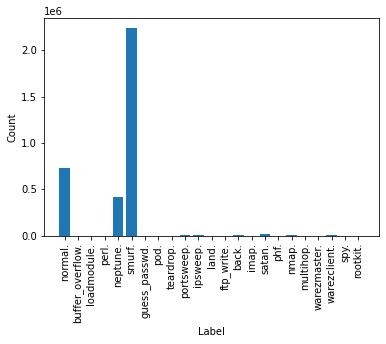

In [ ]:
import matplotlib.pyplot as plt
plt.bar(DF_labels['Label'], DF_labels['Count'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

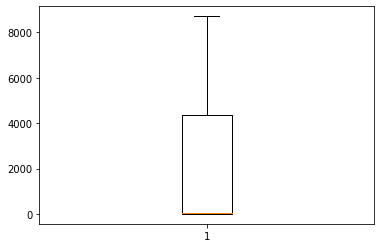

In [ ]:
plt.boxplot(DF_labels['Count'],0,'')
plt.show()

In [ ]:
#Exercise 1
rdd_len = KDDcup_rdd.map(lambda x: len(x))

longest_line = rdd_len.reduce(lambda a,b: a if a > b else b)
shortest_line = rdd_len.reduce(lambda a,b: a if a < b else b)

print('the shortest line has '+ str(shortest_line) + 'and the longest line has ' + str(longest_line) + ' chars.')

the shortest line has 139and the longest line has 162 chars.


In [ ]:
#Exercise 2
def src_dst_calc(x):
    src = int(x[1][0])
    dst = int(x[1][1])
    if src == 0:
      return False
    if dst / src > 10:
      return True
    else:
      return False

Split_rdd.map(lambda line: (line[-1], (line[4:6]))) \
         .filter(lambda line: src_dst_calc(line)) \
         .map(lambda line: (line[0], 1)) \
         .reduceByKey(lambda a,b: a + b) \
         .collect()

[('normal.', 188193),
 ('guess_passwd.', 1),
 ('ipsweep.', 1),
 ('ftp_write.', 2),
 ('satan.', 64),
 ('phf.', 3),
 ('multihop.', 2),
 ('imap.', 1),
 ('loadmodule.', 1),
 ('perl.', 1),
 ('rootkit.', 3)]

In [ ]:
Src_bytes_rdd = Split_rdd.map(lambda x: float(x[4]))
Src_bytes_rdd.takeOrdered(10, key=lambda x: -x) # take 10 numbers in a descending order
Summation = Src_bytes_rdd.reduce(lambda a,b:a+b)
MEAN = Summation / Src_bytes_rdd.count()
print("the mean value for the number of src bytes is:\t ", MEAN)

the mean value for the number of src bytes is:	  1278.5696276826498


In [ ]:
# Load pyspark.sql for conversion
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [ ]:
features = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot','num_failed_logins','logged_in',
            'num_compromised','root_shell','su_attempted','num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login',
            'is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate',
            'srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate',
            'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','label']

KDDcup_df = spark.createDataFrame(Split_rdd, features)

In [ ]:
KDDcup_df = KDDcup_df.na.drop()
KDDcup_df.show(5)

+--------+-------------+-------+----+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+-------+
|duration|protocol_type|service|flag|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|num_outbound_cmds|is_host_login|is_guest_login|count|srv_count|serror_rate|srv_serror_rate|rerror_rate|srv_rerror_rate|same_srv_rate|diff_srv_rate|srv_diff_host_rate|dst_hos

In [ ]:
from pyspark.sql.functions import col

KDDcup_df.withColumn("dst_bytes", col("dst_bytes").cast("Integer"))

DataFrame[duration: string, protocol_type: string, service: string, flag: string, src_bytes: string, dst_bytes: int, land: string, wrong_fragment: string, urgent: string, hot: string, num_failed_logins: string, logged_in: string, num_compromised: string, root_shell: string, su_attempted: string, num_root: string, num_file_creations: string, num_shells: string, num_access_files: string, num_outbound_cmds: string, is_host_login: string, is_guest_login: string, count: string, srv_count: string, serror_rate: string, srv_serror_rate: string, rerror_rate: string, srv_rerror_rate: string, same_srv_rate: string, diff_srv_rate: string, srv_diff_host_rate: string, dst_host_count: string, dst_host_srv_count: string, dst_host_same_srv_rate: string, dst_host_diff_srv_rate: string, dst_host_same_src_port_rate: string, dst_host_srv_diff_host_rate: string, dst_host_serror_rate: string, dst_host_srv_serror_rate: string, dst_host_rerror_rate: string, dst_host_srv_rerror_rate: string, label: string]

In [ ]:
from pyspark.sql.functions import when

df = KDDcup_df.withColumn("protocol_type", when(KDDcup_df.protocol_type == "tcp", 1) # or: col("protocol_type") == "TCP"
                                      .when(KDDcup_df.protocol_type == "udp", 2)
                                      .when(KDDcup_df.protocol_type == "icmp", 3)
                                      .when(KDDcup_df.protocol_type.isNull(), 4)
                                      .otherwise(5))

df.show(10)

+--------+-------------+-------+----+---------+---------+----+--------------+------+---+-----------------+---------+---------------+----------+------------+--------+------------------+----------+----------------+-----------------+-------------+--------------+-----+---------+-----------+---------------+-----------+---------------+-------------+-------------+------------------+--------------+------------------+----------------------+----------------------+---------------------------+---------------------------+--------------------+------------------------+--------------------+------------------------+-------+
|duration|protocol_type|service|flag|src_bytes|dst_bytes|land|wrong_fragment|urgent|hot|num_failed_logins|logged_in|num_compromised|root_shell|su_attempted|num_root|num_file_creations|num_shells|num_access_files|num_outbound_cmds|is_host_login|is_guest_login|count|srv_count|serror_rate|srv_serror_rate|rerror_rate|srv_rerror_rate|same_srv_rate|diff_srv_rate|srv_diff_host_rate|dst_hos

In [ ]:
KDDcup_df.select('src_bytes').describe().show()

+-------+------------------+
|summary|         src_bytes|
+-------+------------------+
|  count|           3409269|
|   mean|1278.5696276826498|
| stddev| 377044.2884421606|
|    min|                 0|
|    max|               999|
+-------+------------------+



In [ ]:
KDDcup_df.select(['src_bytes', 'dst_bytes']).describe().show()

+-------+------------------+------------------+
|summary|         src_bytes|         dst_bytes|
+-------+------------------+------------------+
|  count|           3409269|           3409269|
|   mean|1278.5696276826498|1438.5082429693873|
| stddev| 377044.2884421606| 773118.0183483473|
|    min|                 0|                 0|
|    max|               999|              9999|
+-------+------------------+------------------+

